In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tkinter import filedialog, Tk


In [2]:
def split_dataset(original_dir, base_dir, split_ratio=0.8):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        os.makedirs(os.path.join(base_dir, 'train'))
        os.makedirs(os.path.join(base_dir, 'validation'))

    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            split_point = int(len(images) * split_ratio)
            train_images = images[:split_point]
            val_images = images[split_point:]

            os.makedirs(os.path.join(base_dir, 'train', class_name), exist_ok=True)
            os.makedirs(os.path.join(base_dir, 'validation', class_name), exist_ok=True)

            for img in train_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'train', class_name, img))

            for img in val_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'validation', class_name, img))


In [3]:
train_dir = 'dataset'
val_dir = 'dataset'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical'
)

Found 400 images belonging to 4 classes.


Found 400 images belonging to 4 classes.


In [4]:
img_size = (225, 255)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    'dataset',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    'dataset',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [5]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)


In [6]:
# Cek urutan label
print(train_generator.class_indices)


{'Balungan': 0, 'Bonang': 1, 'Kendang': 2, 'Slentho': 3}


In [7]:
from tensorflow.keras.callbacks import Callback

class StopTrainingAtAccuracy(Callback):
    def __init__(self, target=0.85):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')  # You can also use 'val_accuracy' if monitoring validation
        if accuracy is not None and accuracy >= self.target:
            print(f"\nReached {self.target * 100:.0f}% accuracy, stopping training.")
            self.model.stop_training = True


In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(255,255,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary() 

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)


Epoch 1/15


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.3628 - loss: 2.2757 - val_accuracy: 0.5850 - val_loss: 0.9022
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.5804 - loss: 0.8980 - val_accuracy: 0.6700 - val_loss: 0.7745
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.7232 - loss: 0.7350 - val_accuracy: 0.8200 - val_loss: 0.4984
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.7668 - loss: 0.5625 - val_accuracy: 0.8850 - val_loss: 0.2957
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.7915 - loss: 0.4722 - val_accuracy: 0.9300 - val_loss: 0.2276
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.8980 - loss: 0.2866 - val_accuracy: 0.9500 - val_loss: 0.1299
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.9293 - loss: 0.1809 - val_accuracy: 0.9800 - val_loss: 0.0938
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.9496 - loss: 0.1783 - val_accuracy: 0.9800 - val_loss: 0.0681
Ep

In [10]:
loss, accuracy = model.evaluate(val_generator)
print(f"\nAkurasi: {accuracy*100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9654 - loss: 0.0734

Akurasi: 97.50%


In [11]:
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {prediction[0][i]*100:.2f}%")

NameError: name 'class_names' is not defined

In [ ]:
# Prediksi seluruh data validasi
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


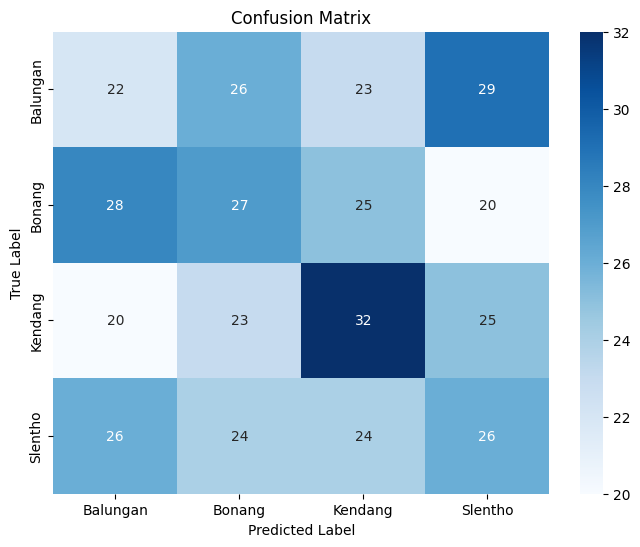

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
# Classification Report (Precision, Recall, F1-Score)
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    Balungan       0.23      0.22      0.22       100
      Bonang       0.27      0.27      0.27       100
     Kendang       0.31      0.32      0.31       100
     Slentho       0.26      0.26      0.26       100

    accuracy                           0.27       400
   macro avg       0.27      0.27      0.27       400
weighted avg       0.27      0.27      0.27       400



In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro-Averaged F1 Score: {f1:.4f}")


Macro-Averaged F1 Score: 0.2671


In [ ]:
model.save('model_alat_musik.h5')
print("Model berhasil disimpan sebagai 'model_alat_musik.h5'")

Model berhasil disimpan sebagai 'model_alat_musik.h5'


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tkinter import filedialog, Tk

# 1. Pilih gambar
root = Tk()
root.withdraw()
file_path = filedialog.askopenfilename(title='Pilih gambar', filetypes=[("Image files", "*.jpg *.png *.jpeg")])

if not file_path:
    print("Tidak ada file dipilih.")
else:
    # 2. Load dan praproses gambar (ganti ukuran sesuai input model kamu)
    img = image.load_img(file_path, target_size=(255, 255, 3))  # Ganti target_size sesuai input model
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 3. Prediksi
    prediction = model.predict(img_array)

    # 4. Tampilkan hasil
    class_names = ['Balungan', 'Bonang', 'Kendang', 'Slentho']  # SESUAIKAN dengan train_generator.class_indices
    predicted_label = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_label} ({np.max(prediction)*100:.2f}%)")
    plt.show()


NameError: name 'model' is not defined